In [1]:
import sys
import os
# Add the 'scripts/' directory to the system path
sys.path.append(os.path.abspath('../triple_mbhb'))

In [2]:
import Trip_utils as util
import numpy as np
import Triple_dynamics as Tr
import spin_models as spin
import matplotlib.pyplot as plt
from tqdm import tqdm
import Trip_utils as util
import Kickrateplots as kickplots
import merger_rate_calculate as mr
from scipy.stats import binned_statistic

In [3]:
import astropy.units as u
from astropy import constants as const

### Load the objects

In [4]:
import pickle
Nruns = 100

iso_filename = os.path.abspath('../obj_data/iso_bin.pkl')
weak_tr_filename = os.path.abspath('../obj_data/weak_tr.pkl')
strong_tr_filename =os.path.abspath(f'../obj_data/tr{Nruns}.pkl')
stalled_tr_filename=os.path.abspath(f'../obj_data/stalled{Nruns}.pkl')

In [326]:
with open(iso_filename, 'rb') as f:
    iso_bin = pickle.load(f)

with open(weak_tr_filename, 'rb') as f:
    weak_tr = pickle.load(f)

with open(strong_tr_filename, 'rb') as f:
    strong_tr = pickle.load(f)

with open(stalled_tr_filename, 'rb') as f:
    stalled_objs = pickle.load(f)

#### Spin model plot

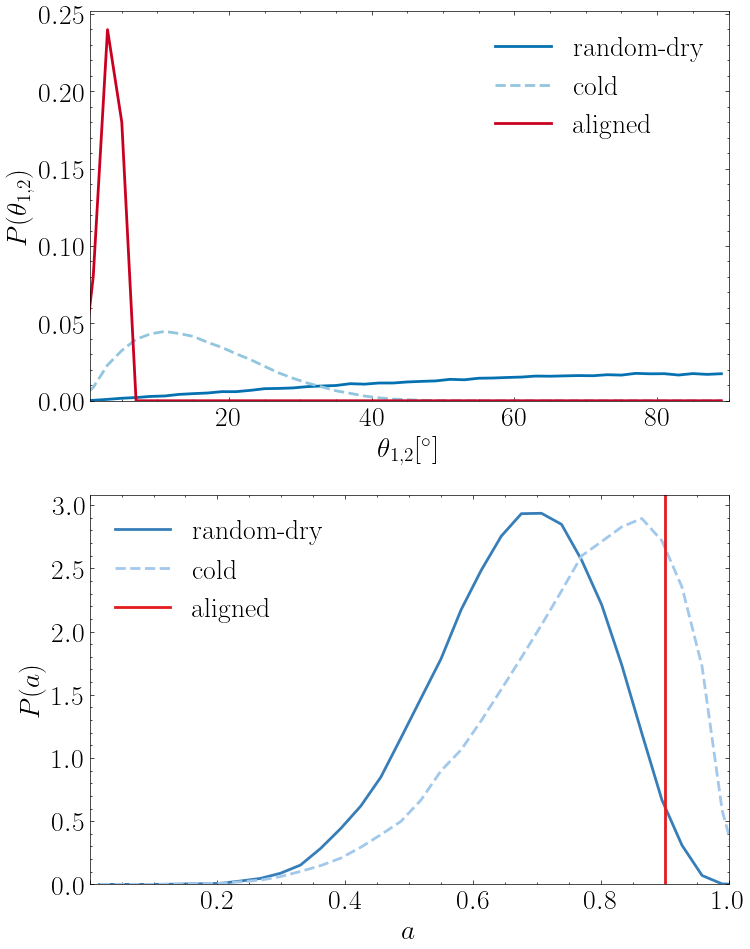

In [33]:
fig,axes = kickplots.plot_spin_dist()
fig.savefig("../Figures/spin-models-magnitude-and-angle.pdf")

### PDF of velocities 

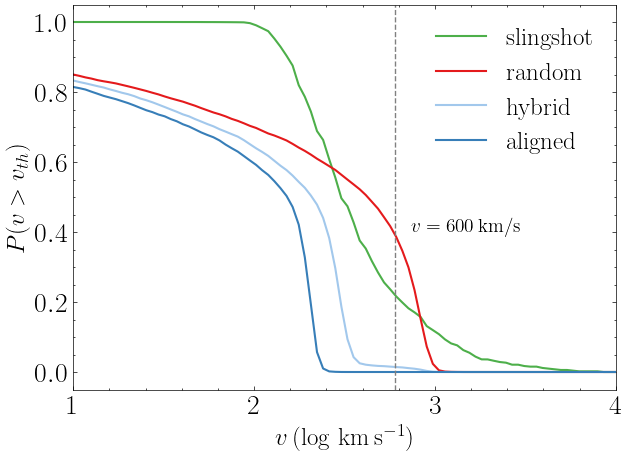

In [35]:
fig2,ax2 = kickplots.Prob_kick(strong_tr,weak_tr,iso_bin,Nruns,N_v=90)
ax2.set_xticks([1,2,3,4])
ax2.axvline(x=np.log10(600),color="grey",linestyle="--")
ax2.set_xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=18)
ax2.set_xlim(1,4)
ax2.text(np.log10(600)+0.09,0.4,r'$v = 600\, \text{km}/\text{s}$',fontsize=14)
fig2.savefig("../Figures/P_v_greater_than_vth.pdf")

In [6]:

rand_max = []
hyb_max=[]
aligned_max = []
sling_max = []

rand_below10 = []
rand_above_600 = []
sling_above_600 = []
hyb_above_600 = []

for i in range(Nruns):
    random_kicks = np.concatenate([strong_tr[i].gw_kick_random,iso_bin.gw_kick_random,weak_tr.gw_kick_random])
    hybrid_kicks = np.concatenate([strong_tr[i].gw_kick_hybrid,iso_bin.gw_kick_hybrid,weak_tr.gw_kick_hybrid])
    aligned_kicks = np.concatenate([strong_tr[i].gw_kick_5deg,iso_bin.gw_kick_5deg,weak_tr.gw_kick_5deg])
    slingshot_kicks = np.array(strong_tr[i].slingshot_kicks)

    rand_below10.append(len(random_kicks[random_kicks<=10])/len(random_kicks) * 100)
    rand_above_600.append(len(random_kicks[random_kicks>=600])/len(random_kicks) * 100)
    rand_max.append(np.max(random_kicks))

    sling_above_600.append(len(slingshot_kicks[slingshot_kicks>=600])/len(slingshot_kicks) * 100)
    sling_max.append(np.max(slingshot_kicks))

    hyb_above_600.append(len(hybrid_kicks[hybrid_kicks>=600])/len(hybrid_kicks) * 100)
    hyb_max.append(np.max(hybrid_kicks))
    aligned_max.append(np.max(aligned_kicks))


In [7]:
print(f"Around {np.mean(rand_below10):.2f} % of random GW kicks are below 10 km/s")
print(f"Around {np.mean(rand_above_600):.1f} % of random GW kicks are above 600 km/s")
print(f"Around {np.mean(sling_above_600):.2f} % of slingshot GW kicks are above 600 km/s")
print(f"Around {np.mean(hyb_above_600):.2f} % of hybrid GW kicks are above 600 km/s")

Around 17.03 % of random GW kicks are below 10 km/s
Around 38.5 % of random GW kicks are above 600 km/s
Around 22.24 % of slingshot GW kicks are above 600 km/s
Around 1.42 % of hybrid GW kicks are above 600 km/s


In [8]:
isobin_random_kicks = np.array(iso_bin.gw_kick_random)
print(f"Around {len(isobin_random_kicks[isobin_random_kicks<=10])/len(isobin_random_kicks) * 100:.2f} % of random GW kicks are below 10 km/s")
print(f"The average inner mass ratio for these low velocity kicks is {np.mean(iso_bin.qin[isobin_random_kicks<=10]):.4f}")
print(f"The average inner mass ratio for these low velocity kicks is {np.mean(np.log10(iso_bin.M1[isobin_random_kicks<=10])):.4f}")
print(f"The average inner mass ratio for these low velocity kicks is {np.mean(np.log10(iso_bin.M2[isobin_random_kicks<=10])):.4f}")

Around 13.89 % of random GW kicks are below 10 km/s
The average inner mass ratio for these low velocity kicks is 0.0076
The average inner mass ratio for these low velocity kicks is 8.8040
The average inner mass ratio for these low velocity kicks is 6.4851


In [9]:
print(f"The maximum kick in random GW recoil is about {np.mean(rand_max):.1f} km/s")
print(f"The maximum kick in hybrid GW recoil is about {np.mean(hyb_max):.1f} km/s")
print(f"The maximum kick in aligned GW recoil is about {np.mean(aligned_max):.1f} km/s")
print(f"The maximum kick in slingshot kick is about {np.mean(sling_max):.1f} km/s")

The maximum kick in random GW recoil is about 1388.2 km/s
The maximum kick in hybrid GW recoil is about 1130.3 km/s
The maximum kick in aligned GW recoil is about 311.9 km/s
The maximum kick in slingshot kick is about 8149.6 km/s


In [10]:
rand_max = np.mean(rand_max)
sling_above_rand_max = []
for i in range(Nruns):
    slingshot_kicks = np.array(strong_tr[i].slingshot_kicks)
    sling_above_rand_max.append(len(slingshot_kicks[slingshot_kicks>=rand_max])/len(slingshot_kicks) * 100)

In [11]:
print(f"Around {np.mean(sling_above_rand_max):.1f} % of slingshot kicks are above the maximum kick produced by random GW recoil")

Around 6.6 % of slingshot kicks are above the maximum kick produced by random GW recoil


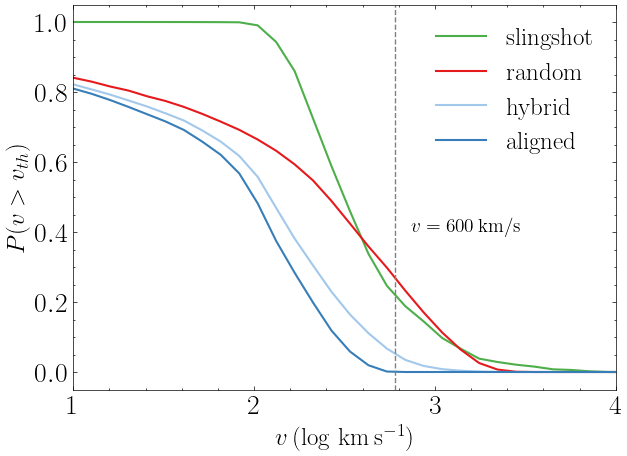

In [14]:
fig2,ax2 = kickplots.Prob_kick(strong_tr,weak_tr,iso_bin,Nruns)
ax2.set_xticks([1,2,3,4])
ax2.axvline(x=np.log10(600),color="grey",linestyle="--")
ax2.set_xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=18)
ax2.set_xlim(1,4)
ax2.text(np.log10(600)+0.09,0.4,r'$v = 600\, \text{km}/\text{s}$',fontsize=14)
#fig2.savefig("../Figures/P_v_greater_than_vth.pdf")

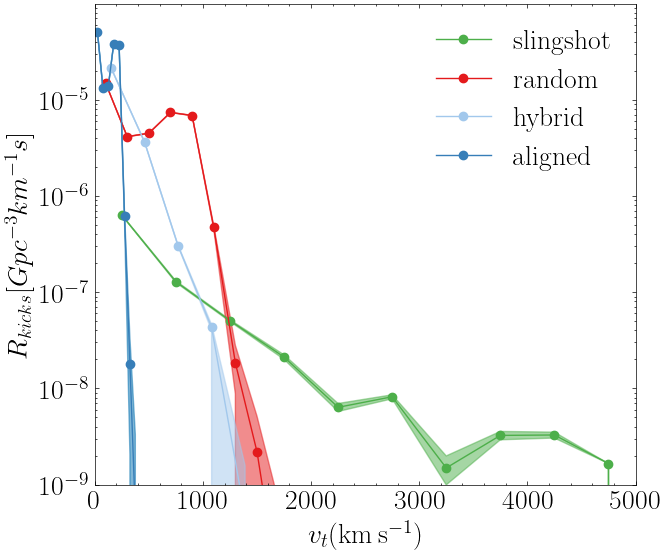

In [172]:
fig3,ax3 = kickplots.plot_rate_kicks(strong_tr,weak_tr,iso_bin,v_max_values= {"sling":9000,"random":3200,"hybrid":3100,"deg5":600},vbin_sizes={"sling":500,"random":200,"hybrid":300,"deg5":50},Nruns=Nruns)
ax3.set_ylim(1e-9,)
ax3.set_xlabel(r"$v_t (\text{km} \, \text{s}^{-1})$")
ax3.set_xlim(0,5000)
fig3.savefig("../Figures/kick_rates_for_spins.pdf")

In [159]:
vth_sling = np.arange(0,8000,400)
sling_vth = []
for vth in vth_sling:
    sling_vth.append(np.mean(kickplots.Nkicks(strong_tr,weak_tr,iso_bin,vth,Nruns)[3]))

vth_rand = np.arange(0,1700,150)
random_vth = []
for vth in vth_rand:
    random_vth.append(np.mean(kickplots.Nkicks(strong_tr,weak_tr,iso_bin,vth,Nruns)[0]))

vth_hybrid = np.arange(0,1200,150)
hybrid_vth = []
for vth in vth_hybrid:
    hybrid_vth.append(np.mean(kickplots.Nkicks(strong_tr,weak_tr,iso_bin,vth,Nruns)[2]))

vth_aligned = np.arange(0,500,50)
aligned_vth = []
for vth in vth_aligned:
    aligned_vth.append(np.mean(kickplots.Nkicks(strong_tr,weak_tr,iso_bin,vth,Nruns)[1]))

In [160]:
kick_colors = {'slingshot':"#4daf4a",'aligned':"#377eb8","hybrid":"#a2c8ec","random":"#e41a1c"}


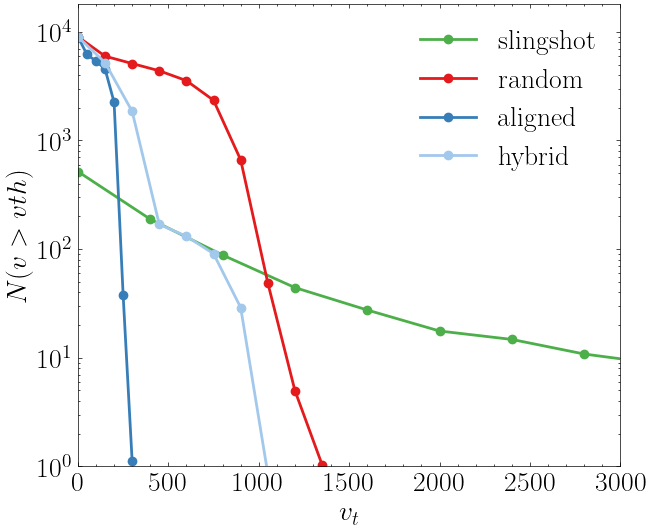

In [173]:
plt.figure(figsize=(7, 6))
plt.plot(vth_sling,sling_vth, linestyle='-', linewidth=2,marker='o', color=kick_colors["slingshot"], label="slingshot")
plt.plot(vth_rand,random_vth, linestyle='-',linewidth=2, marker='o', color=kick_colors["random"], label="random")
plt.plot(vth_aligned,aligned_vth, linestyle='-',linewidth=2, marker='o', color=kick_colors["aligned"], label="aligned")
plt.plot(vth_hybrid,hybrid_vth, linestyle='-', linewidth=2,marker='o', color=kick_colors["hybrid"], label="hybrid")
plt.yscale("log",base=10)
plt.ylim(1,)
plt.xlim(0,3000)
plt.legend()
plt.xlabel("$v_t$")
plt.ylabel("$N(v>vth)$")
plt.savefig("../Figures/Nkicks_for_spins.pdf")

## Ejection rates

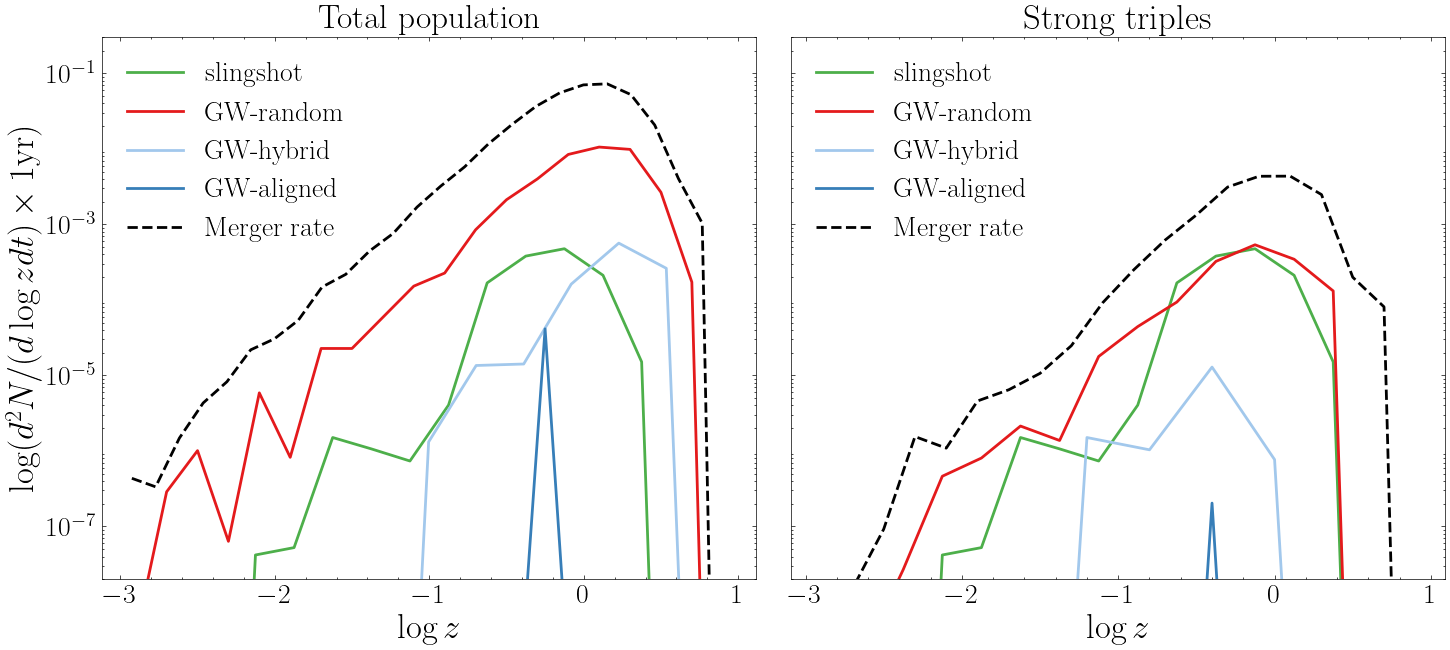

In [33]:
fig,ax = Tr.plot_ejection_rates(strong_tr,weak_tr,iso_bin,Nruns)
ax[0].set_title("Total population")
fig.savefig(f"../Figures/ejection_rates_all_and_triples_{Nruns:d}.pdf")

In [58]:
print(f"The median Vesc value is {np.median(np.concatenate([iso_bin.Vescape,weak_tr.Vescape,strong_tr[0].Vescape])):.2f} km/s")
Vesc_med_below4 = np.median(np.concatenate([iso_bin.Vescape[iso_bin.z_merger<4],weak_tr.Vescape[weak_tr.z_merger<4],strong_tr[0].Vescape[strong_tr[0].z_triple_merger<4]]))
Vesc_med_above4 =np.median(np.concatenate([iso_bin.Vescape[iso_bin.z_merger>=4],weak_tr.Vescape[weak_tr.z_merger>=4],strong_tr[0].Vescape[strong_tr[0].z_triple_merger>=4]]))
print(f"The median Vesc above z=4 value is {Vesc_med_above4:.2f} km/s")
print(f"The median Vesc above z=4 value is {Vesc_med_below4:.2f} km/s")

The median Vesc value is 1269.48 km/s
The median Vesc above z=4 value is 1095.17 km/s
The median Vesc above z=4 value is 1269.72 km/s


In [75]:
min_z = []
for i in range(Nruns):
    min_z.append([i,np.min(np.log10(strong_tr[i].z_triple_merger[strong_tr[i].merger_mask]))])
min_z = np.array(min_z)
min_run = np.argmin(min_z[:,1])
print(min_run,np.min(min_z[:,1]))

76 -4.436046208350423


In [76]:
def optimized_fixed_bins_fraction(logz_total, lgzmin, lgzmax, initial_binsize, min_mergers):
    """
    Finds an optimized bin size such that each bin has at least min_mergers 
    and computes the fraction of strong mergers (N_strong / N_total) for each bin.
    The bin size is consistent across the entire range, except for the first bin, 
    which can have fewer than min_mergers.
    """
    optimized_binsize = initial_binsize
    
    # Initialize the binning with the starting bin size
    while True:
        bins = np.arange(lgzmin - optimized_binsize, lgzmax + optimized_binsize, optimized_binsize)
        total_bin_counts, bin_edges = np.histogram(logz_total, bins=bins)
        # Allow the first bin to have less than the minimum mergers
        if np.all(total_bin_counts[1:] >= min_mergers):  # Only check bins after the first
            break  # The bin size is adequate, so we stop
        else:
            optimized_binsize *= 1.1  # Increase the bin size slightly

    # Calculate bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, bin_edges, optimized_binsize

In [77]:
def fraction_ejection_fraction_for_plot(lgz_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize):
    
    bins_kick = np.arange(lgzmin,lgzmax+binsize,binsize)

    N_mrgr,lgzbin_edges=np.histogram(lgz_mrgrs,bins=bins_kick)
    N_ejec,_ = np.histogram(lgz_ejec,bins=bins_kick)
    non_zero_mask = N_mrgr > 0
    fraction_ejected = np.zeros_like(N_mrgr, dtype=float)
    fraction_ejected[non_zero_mask] = N_ejec[non_zero_mask] / N_mrgr[non_zero_mask]
    bin_centers = (lgzbin_edges[:-1] + lgzbin_edges[1:]) / 2

    return bin_centers,fraction_ejected

In [109]:
lgzmin = -4      # Minimum log10 redshift
lgzmax = 1       # Maximum log10 redshift
i = min_run

lgz_mergers = np.log10(strong_tr[i].z_triple_merger[strong_tr[i].merger_mask])
lgzbins,final_bin_edges,optimized_binsize = optimized_fixed_bins_fraction(lgz_mergers, lgzmin, lgzmax, initial_binsize=0.01, min_mergers=1)

In [110]:
lgzmax = 1
lgzmin = -4
min_mergers = 2
binsize_eject = optimized_binsize 
print(optimized_binsize)


1.718719477011626


In [157]:
lgzmax = 1
lgzmin = -4.4
min_mergers = 2
binsize_sling = optimized_binsize-0.5
binsize_rand = optimized_binsize - 0.95
binsize_hybrid = optimized_binsize -0.5
binsize_aligned = optimized_binsize-0.5

# bins = np.arange(lgzmin, lgzmax + binsize_eject, binsize_eject)
# bins_sling = np.arange(lgzmin, lgzmax + binsize_eject, binsize_eject)
# bins_rand = np.arange(lgzmin, lgzmax + binsize_eject, binsize_eject)
# bins_hybrid = np.arange(lgzmin, lgzmax + binsize_eject, binsize_eject)
# bins_aligned = np.arange(lgzmin, lgzmax + binsize_eject, binsize_eject)

accumulated_fraction_sling = []
accumulated_fraction_rand = []
accumulated_fraction_hybrid = []
accumulated_fraction_aligned = []

for i in range(Nruns):
    lgz_sling_ejec = np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].slingshot_kicks>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)])
    lgz_rand_ejec = np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_random>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)])
    lgz_hybrid_ejec = np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_hybrid>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)])
    lgz_aligned_ejec = np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_5deg>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)])
    lgz_mrgrs = np.log10(strong_tr[i].z_triple_merger[strong_tr[i].merger_mask])

    bin_centers_sling,fraction_ejected_sling = fraction_ejection_fraction_for_plot(lgz_sling_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_sling)
    accumulated_fraction_sling.append(fraction_ejected_sling)

    bin_centers_rand,fraction_ejected_rand = fraction_ejection_fraction_for_plot(lgz_rand_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_rand)
    accumulated_fraction_rand.append(fraction_ejected_rand)

    bin_centers_hybrid,fraction_ejected_hybrid = fraction_ejection_fraction_for_plot(lgz_hybrid_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_hybrid)
    accumulated_fraction_hybrid.append(fraction_ejected_hybrid)

    bin_centers_aligned,fraction_ejected_aligned = fraction_ejection_fraction_for_plot(lgz_aligned_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_aligned)
    accumulated_fraction_aligned.append(fraction_ejected_aligned)

In [158]:
bin_centers_sling_st = bin_centers_sling
bin_centers_rand_st = bin_centers_rand
bin_centers_hybrid_st = bin_centers_hybrid
bin_centers_aligned_st = bin_centers_aligned

accumulated_fraction_sling_st = accumulated_fraction_sling
accumulated_fraction_rand_st = accumulated_fraction_rand
accumulated_fraction_hybrid_st = accumulated_fraction_hybrid
accumulated_fraction_aligned_st =accumulated_fraction_aligned

In [159]:
bin_centers_rand_st

array([-4.01564026, -3.24692078, -2.47820131, -1.70948183, -0.94076235,
       -0.17204288,  0.5966766 ,  1.36539608])

In [160]:
np.mean(accumulated_fraction_rand,axis=0)

array([0.01      , 0.02333333, 0.2175    , 0.25826052, 0.1390759 ,
       0.12272407, 0.0773053 , 0.        ])

Text(0, 0.5, 'Fraction of ejections')

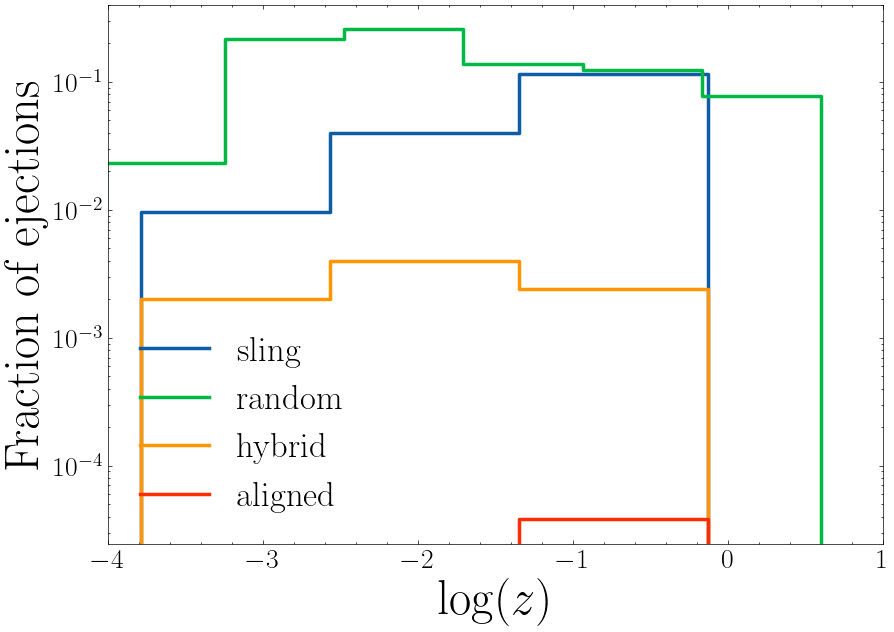

In [161]:
plt.figure(figsize=[10,7])
plt.step(bin_centers_sling_st,np.mean(accumulated_fraction_sling,axis=0),label="sling",linewidth =2.5)
plt.step(bin_centers_rand_st,np.mean(accumulated_fraction_rand,axis=0),label="random",linewidth =2.5)
plt.step(bin_centers_hybrid_st,np.mean(accumulated_fraction_hybrid,axis=0),label="hybrid",linewidth =2.5)
plt.step(bin_centers_aligned_st,np.mean(accumulated_fraction_aligned,axis=0),label="aligned",linewidth =2.5)
plt.yscale("log")
plt.xlim(-4,1)
plt.legend(fontsize=25)
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)

In [167]:
lgzmin = -4      # Minimum log10 redshift
lgzmax = 1       # Maximum log10 redshift
i = min_run

lgz_mergers = np.concatenate([np.log10(strong_tr[i].z_triple_merger[strong_tr[i].merger_mask]),np.log10(iso_bin.z_merger[iso_bin.merger_mask]),np.log10(weak_tr.z_merger[weak_tr.merger_mask])]) 
lgzbins,final_bin_edges,optimized_binsize = optimized_fixed_bins_fraction(lgz_mergers, lgzmin, lgzmax, initial_binsize=0.01, min_mergers=4)
print(optimized_binsize)


1.0671895716335977


In [168]:
lgzmax = 1
lgzmin = -4
#min_mergers = 2
binsize_sling = optimized_binsize + 0.1
binsize_rand = optimized_binsize 
binsize_hybrid = optimized_binsize  + 0.2
binsize_aligned = optimized_binsize +0.3


accumulated_fraction_sling = []
accumulated_fraction_rand = []
accumulated_fraction_hybrid = []
accumulated_fraction_aligned = []

for i in range(Nruns):
    
    lgz_mrgrs = np.concatenate([np.log10(strong_tr[i].z_triple_merger[strong_tr[i].merger_mask]),np.log10(iso_bin.z_merger[iso_bin.merger_mask]),np.log10(weak_tr.z_merger[weak_tr.merger_mask])]) 
    lgz_sling_ejec = np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].slingshot_kicks>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)])
    lgz_rand_ejec = np.concatenate([np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_random>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)]),
                                    np.log10(iso_bin.z_merger[(iso_bin.gw_kick_random>iso_bin.Vescape)&(iso_bin.z_merger>0)]),
                                    np.log10(weak_tr.z_merger[(weak_tr.gw_kick_random>weak_tr.Vescape)&(weak_tr.z_merger>0)])])
    
    lgz_hybrid_ejec = np.concatenate([np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_hybrid>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)]),
                                    np.log10(iso_bin.z_merger[(iso_bin.gw_kick_hybrid>iso_bin.Vescape)&(iso_bin.z_merger>0)]),
                                    np.log10(weak_tr.z_merger[(weak_tr.gw_kick_hybrid>weak_tr.Vescape)&(weak_tr.z_merger>0)])])

    lgz_aligned_ejec = np.concatenate([np.log10(strong_tr[i].z_triple_merger[(strong_tr[i].gw_kick_5deg>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)]),
                                    np.log10(iso_bin.z_merger[(iso_bin.gw_kick_5deg>iso_bin.Vescape)&(iso_bin.z_merger>0)]),
                                    np.log10(weak_tr.z_merger[(weak_tr.gw_kick_5deg>weak_tr.Vescape)&(weak_tr.z_merger>0)])])

    bin_centers_sling,fraction_ejected_sling = fraction_ejection_fraction_for_plot(lgz_sling_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_sling)
    accumulated_fraction_sling.append(fraction_ejected_sling)

    bin_centers_rand,fraction_ejected_rand = fraction_ejection_fraction_for_plot(lgz_rand_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_rand)
    accumulated_fraction_rand.append(fraction_ejected_rand)

    bin_centers_hybrid,fraction_ejected_hybrid = fraction_ejection_fraction_for_plot(lgz_hybrid_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_hybrid)
    accumulated_fraction_hybrid.append(fraction_ejected_hybrid)

    bin_centers_aligned,fraction_ejected_aligned = fraction_ejection_fraction_for_plot(lgz_aligned_ejec,lgz_mrgrs,lgzmax,lgzmin,binsize_aligned)
    accumulated_fraction_aligned.append(fraction_ejected_aligned)

In [169]:
hybrid_N = np.mean(accumulated_fraction_hybrid,axis=0)
hybrid_N = np.append(hybrid_N,0)
hybrid_N[0]=0
bin_centers_hybrid = np.append(bin_centers_hybrid,bin_centers_hybrid[-1]+binsize_hybrid/2)

rand_N = np.mean(accumulated_fraction_rand,axis=0)
rand_N = np.append(rand_N,0)
rand_N[0]=0
bin_centers_rand = np.append(bin_centers_rand,bin_centers_rand[-1]+binsize_rand/2)

In [170]:

aligned_N = np.mean(accumulated_fraction_aligned,axis=0)
sling_N = np.mean(accumulated_fraction_sling,axis=0)


Text(0, 0.5, 'Fraction of ejections')

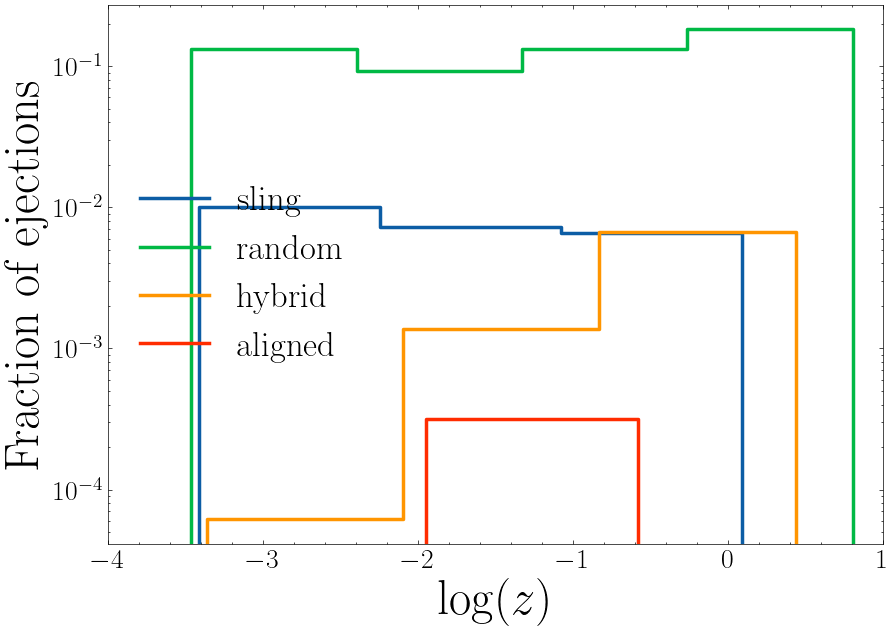

In [171]:
plt.figure(figsize=[10,7])
plt.step(bin_centers_sling,np.mean(accumulated_fraction_sling,axis=0),label="sling",linewidth =2.5)
plt.step(bin_centers_rand,rand_N,label="random",linewidth =2.5)
plt.step(bin_centers_hybrid,hybrid_N,label="hybrid",linewidth =2.5)
plt.step(bin_centers_aligned,np.mean(accumulated_fraction_aligned,axis=0),label="aligned",linewidth =2.5)
plt.yscale("log")
plt.xlim(-4,1)
plt.legend(fontsize=25)
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)

In [172]:
kick_colors = {'slingshot':"#4daf4a",'aligned':"#377eb8","hybrid":"#a2c8ec","random":"#e41a1c"}

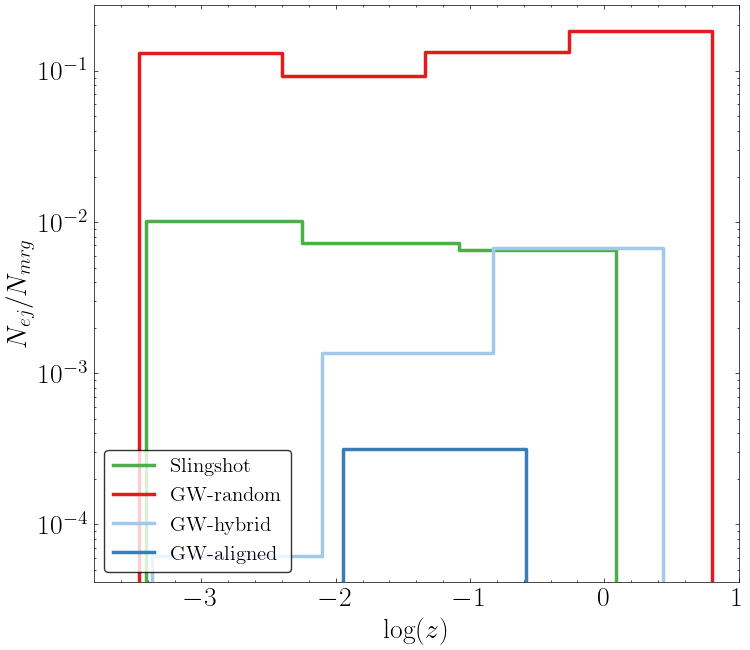

In [185]:
fig,ax = plt.subplots(figsize=(8,7))
# ax[1].step(bin_centers_sling_st,np.mean(accumulated_fraction_sling_st,axis=0),label="Slingshot",linewidth =2.5,color=kick_colors['slingshot'])
# ax[1].step(bin_centers_rand_st,np.mean(accumulated_fraction_rand_st,axis=0),label="GW-random",linewidth =2.5,color=kick_colors['random'])
# ax[1].step(bin_centers_hybrid_st,np.mean(accumulated_fraction_hybrid_st,axis=0),label="GW-hybrid",linewidth =2.5,color=kick_colors['hybrid'])
# ax[1].step(bin_centers_aligned_st,np.mean(accumulated_fraction_aligned_st,axis=0),label="GW-aligned",linewidth =2.5,color=kick_colors['aligned'])
# ax[1].set_yscale("log")
# #ax[1].legend(loc="lower right",fontsize=10)
# ax[1].set_ylabel("N(ejections)/N(mergers)")
# ax[1].set_xlabel("$\log(z)$")
# ax[1].set_xlim(-3.8,1)
# ax[1].set_title("Strong triples")


ax.step(bin_centers_sling,sling_N,label="Slingshot",linewidth =2.5,color=kick_colors['slingshot'])
ax.step(bin_centers_rand,rand_N,label="GW-random",linewidth =2.5,color=kick_colors['random'])
ax.step(bin_centers_hybrid,hybrid_N,label="GW-hybrid",linewidth =2.5,color=kick_colors['hybrid'])
ax.step(bin_centers_aligned,aligned_N,label="GW-aligned",linewidth =2.5,color=kick_colors['aligned'])
ax.set_yscale("log")
ax.set_ylabel("$N_{ej}/N_{mrg}$")
ax.set_xlabel("$\log(z)$")
ax.set_xlim(-3.8,1)
ax.legend(fontsize=15,loc="lower left",frameon=True, edgecolor="black", facecolor="white")
plt.tight_layout()
fig.savefig("../Figures/ejection_fraction_for_total_population.pdf")

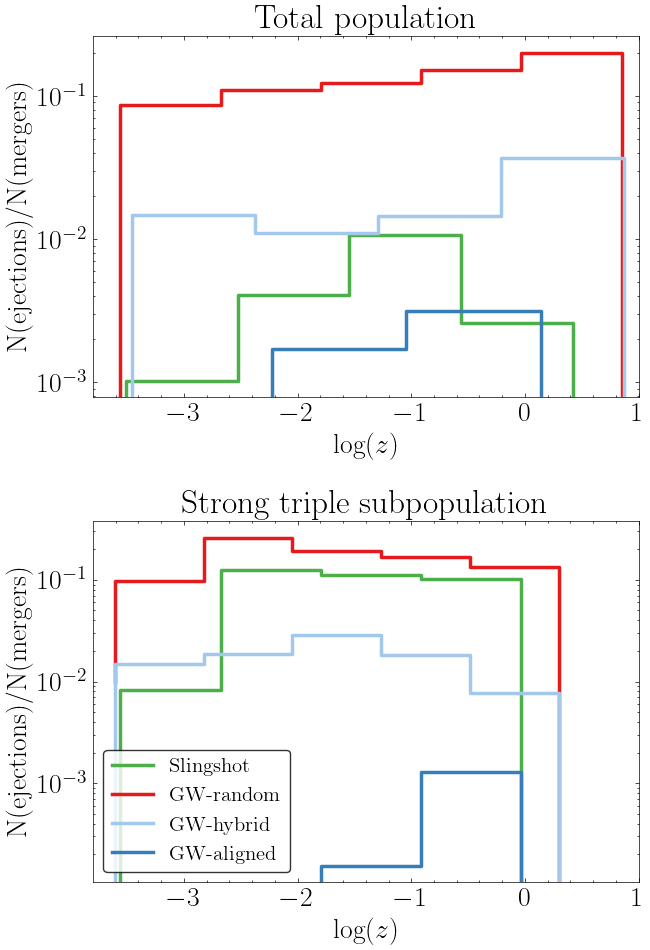

In [535]:
fig,ax = plt.subplots(2,1,figsize=(7,10))
ax[1].step(bin_centers_sling_st,np.mean(accumulated_fraction_sling_st,axis=0),label="Slingshot",linewidth =2.5,color=kick_colors['slingshot'])
ax[1].step(bin_centers_rand_st,np.mean(accumulated_fraction_rand_st,axis=0),label="GW-random",linewidth =2.5,color=kick_colors['random'])
ax[1].step(bin_centers_hybrid_st,np.mean(accumulated_fraction_hybrid_st,axis=0),label="GW-hybrid",linewidth =2.5,color=kick_colors['hybrid'])
ax[1].step(bin_centers_aligned_st,np.mean(accumulated_fraction_aligned_st,axis=0),label="GW-aligned",linewidth =2.5,color=kick_colors['aligned'])
ax[1].set_yscale("log")
ax[1].legend(loc="lower right",fontsize=10)
ax[1].set_ylabel("N(ejections)/N(mergers)")
ax[1].set_xlabel("$\log(z)$")
ax[1].legend(fontsize=15,loc="lower left",frameon=True, edgecolor="black", facecolor="white")
ax[1].set_xlim(-3.8,1)
ax[1].set_title("Strong triple subpopulation")


ax[0].step(bin_centers_sling,sling_N,label="slingshot",linewidth =2.5,color=kick_colors['slingshot'])
ax[0].step(bin_centers_rand,rand_N,label="GW-random",linewidth =2.5,color=kick_colors['random'])
ax[0].step(bin_centers_hybrid,hybrid_N,label="GW-hybrid",linewidth =2.5,color=kick_colors['hybrid'])
ax[0].step(bin_centers_aligned,aligned_N,label="GW-aligned",linewidth =2.5,color=kick_colors['aligned'])
ax[0].set_yscale("log")
ax[0].set_ylabel("N(ejections)/N(mergers)")
ax[0].set_xlabel("$\log(z)$")
ax[0].set_title("Total population")
ax[0].set_xlim(-3.8,1)

plt.tight_layout()
fig.savefig("../Figures/ejection_fraction_for_total_population.pdf")

### Fraction of ejections total

In [264]:
N_slingshot_tr = []
N_random_tr = []
N_aligned_tr = []
N_hybrid_tr = []
N_merger_tr = []

for i in range(Nruns):
    N_slingshot_tr.append(np.sum((strong_tr[i].slingshot_kicks>strong_tr[i].Vescape)&(strong_tr[i].merger_mask)))
    N_random_tr.append(np.sum((strong_tr[i].gw_kick_random>strong_tr[i].Vescape)&(strong_tr[i].merger_mask)))
    N_hybrid_tr.append(np.sum((strong_tr[i].gw_kick_hybrid>strong_tr[i].Vescape)))
    N_aligned_tr.append(np.sum((strong_tr[i].gw_kick_5deg>strong_tr[i].Vescape)))
    N_merger_tr.append(np.sum(strong_tr[i].merger_mask))

N_slingshot_tr = np.mean(N_slingshot_tr)
N_random_tr = np.mean(N_random_tr)
N_aligned_tr = np.mean(N_aligned_tr)
N_hybrid_tr = np.mean(N_hybrid_tr)
N_merger_tr = np.mean(N_merger_tr)

In [267]:
print("In the strong triples subpopulation ...")
print(f"Out of {N_slingshot_tr/N_merger_tr * 100:.1f} % mergers are slingshot ejections")
print(f"Out of {N_random_tr/N_merger_tr * 100:.1f} % mergers are random ejections")
print(f"Out of {N_hybrid_tr/N_merger_tr * 100:.1f} % mergers are hybrid ejections")
print(f"Out of {N_aligned_tr/N_merger_tr * 100:.1f} % mergers are aligned ejections")

In the strong triples subpopulation ...
Out of 10.3 % mergers are slingshot ejections
Out of 12.7 % mergers are random ejections
Out of 0.3 % mergers are hybrid ejections
Out of 0.0 % mergers are aligned ejections


In [238]:
N_slingshot_tr = []
N_random_tr = []
N_aligned_tr = []
N_hybrid_tr = []
N_merger_tr = []

for i in range(Nruns):
    N_slingshot_tr.append(np.sum((strong_tr[i].slingshot_kicks>strong_tr[i].Vescape)&(strong_tr[i].z_triple_merger>0)))
    N_random_tr.append(np.sum((strong_tr[i].gw_kick_random>strong_tr[i].Vescape))+np.sum((iso_bin.gw_kick_random>iso_bin.Vescape)&(iso_bin.merger_mask))+np.sum((weak_tr.gw_kick_random>weak_tr.Vescape)&(weak_tr.merger_mask)))
    N_hybrid_tr.append(np.sum((strong_tr[i].gw_kick_hybrid>strong_tr[i].Vescape))+np.sum((iso_bin.gw_kick_hybrid>iso_bin.Vescape)&(iso_bin.merger_mask))+np.sum((weak_tr.gw_kick_hybrid>weak_tr.Vescape)&(weak_tr.merger_mask)))
    N_aligned_tr.append(np.sum((strong_tr[i].gw_kick_5deg>strong_tr[i].Vescape))+np.sum((iso_bin.gw_kick_5deg>iso_bin.Vescape)&(iso_bin.merger_mask))+np.sum((weak_tr.gw_kick_5deg>weak_tr.Vescape)&(weak_tr.merger_mask)))
    N_merger_tr.append(np.sum(strong_tr[i].merger_mask)+np.sum(iso_bin.merger_mask)+np.sum(weak_tr.merger_mask))

N_slingshot_tr = np.mean(N_slingshot_tr)
N_random_tr = np.mean(N_random_tr)
N_aligned_tr = np.mean(N_aligned_tr)
N_hybrid_tr = np.mean(N_hybrid_tr)
N_merger_tr = np.mean(N_merger_tr)

In [244]:
print("In the total population ...")
print(f"Out of {N_slingshot_tr/N_merger_tr * 100:.1f} % mergers are slingshot ejections")
print(f"Out of {N_random_tr/N_merger_tr * 100:.1f} % mergers are random ejections")
print(f"Out of {N_hybrid_tr/N_merger_tr * 100:.1f} % mergers are hybrid ejections")
print(f"Out of {N_aligned_tr/N_merger_tr * 100:.2f} % mergers are aligned ejections")

In the total population ...
Out of 0.7 % mergers are slingshot ejections
Out of 13.3 % mergers are random ejections
Out of 0.4 % mergers are hybrid ejections
Out of 0.02 % mergers are aligned ejections


### After accounting for ejections

In [306]:
def find_mergers_that_wont_happen(strong_tr,weak_tr,iso_bin,spin_arg):

    fraction_spin = []
    for i in range(Nruns):
        iso_inv,weak_inv,strong_inv = Tr.find_invalid_mergers(strong_tr[i],weak_tr,iso_bin,spin_arg)
        total_no_mergers = np.sum((iso_bin.merger_mask)&(iso_inv))+np.sum((weak_tr.merger_mask)&(weak_inv))+np.sum((strong_tr[i].merger_mask)&strong_inv)
        total_mergers = np.sum(iso_bin.merger_mask)+np.sum(weak_tr.merger_mask)+np.sum(strong_tr[i].merger_mask)
        fraction_spin.append(total_no_mergers/total_mergers)

    return np.mean(fraction_spin)

In [307]:
rand_frac = find_mergers_that_wont_happen(strong_tr,weak_tr,iso_bin,"random")
hyb_frac = find_mergers_that_wont_happen(strong_tr,weak_tr,iso_bin,"hybrid")
aligned_frac = find_mergers_that_wont_happen(strong_tr,weak_tr,iso_bin,"5deg")

In [303]:
print(f"{rand_frac*100:.1f} % of mergers won't happen due to random + slingshot ejections")
print(f"{hyb_frac*100:.1f} % of mergers won't happen due to hybrid + slingshot ejections")
print(f"{aligned_frac*100:.1f} % of mergers won't happen due to aligned + slingshot ejections")

6.3 % of mergers won't happen due to random + slingshot ejections
0.2 % of mergers won't happen due to hybrid + slingshot ejections
0.0 % of mergers won't happen due to aligned + slingshot ejections


In [355]:
tot_merger_rate = []
tot_merger_rate_after_ejec = []

for i in range(Nruns):
    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate.append(iso_mr+strong_mr+weak_mr)
    
    iso_inv_mask,weak_inv_mask,strong_inv_mask = Tr.find_invalid_mergers(strong_tr[0],weak_tr,iso_bin,"random")

    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)&(~weak_inv_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)&(~iso_inv_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)&(~strong_inv_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate_after_ejec.append(iso_mr+strong_mr+weak_mr)


In [356]:
np.mean(tot_merger_rate)

0.40216722661399884

In [358]:
print(f"{np.mean(tot_merger_rate_after_ejec):.2f}")

0.39


In [354]:
weak_mr+iso_mr+strong_mr

0.3876575515063206

In [349]:
weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
strong_mr = mr.merger_rate_find(strong_tr[0].z_triple_merger[(strong_tr[0].merger_mask)],zbinsize=0.2, zmax=7)[1]

In [350]:
weak_mr+iso_mr+strong_mr

0.40337580989761

In [351]:
(0.403-0.402)/0.403 * 100

0.24813895781637738

### Time delay between galaxy merger and MBHB merger

In [1199]:
t_galaxy_merger_iso = iso_bin.t_form[iso_bin.merger_flag=="Yes"]
t_MBHB_merger_iso = iso_bin.t_merger[iso_bin.merger_flag=="Yes"]
Deltat_iso = t_MBHB_merger_iso-t_galaxy_merger_iso

In [1200]:
dT_max = 10.5
dT_min = 6
dT_binsize = 0.5
NdT_iso,dt_edges = np.histogram(np.log10(Deltat_iso),range=(6,10.5),bins=int(dT_max/dT_binsize),density=True)
dtbins_iso = dt_edges[:-1] + 0.5*dT_binsize

In [1201]:
Deltat_strong = []
Deltat_median_strong = []
for i in range(Nruns):
    t_galaxy_merger_strong_triple = strong_tr[i].t_form2[strong_tr[i].merger_mask]
    t_MBHB_strong_triple = strong_tr[i].triple_mergers_times[strong_tr[i].merger_mask]
    Deltat_strong_triple = t_MBHB_strong_triple-t_galaxy_merger_strong_triple
    NdT_strong,dt_edges = np.histogram(np.log10(Deltat_strong_triple),range=(dT_min,dT_max),bins=int(dT_max/dT_binsize),density=True)
    dtbins_strong = dt_edges[:-1] + 0.5*dT_binsize
    Deltat_strong.append(NdT_strong)
    Deltat_median_strong.append(np.median(Deltat_strong_triple))

In [1202]:
np.mean(Deltat_median_strong)/1e9

1.4606330104309644

In [1203]:
np.median(Deltat_iso)/1e9

1.3652376507959079

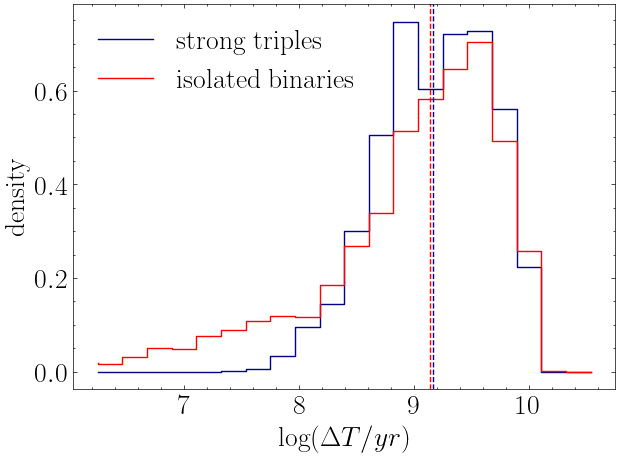

In [1204]:
fig,ax = plt.subplots(figsize=(7,5))
ax.step(dtbins_strong,np.mean(Deltat_strong,axis=0),label="strong triples",color="darkblue")
ax.step(dtbins_iso,NdT_iso,label="isolated binaries",color="red")
ax.set_ylabel("density")
ax.set_xlabel("$\log(\Delta T/yr)$")
ax.legend(loc="upper left")
ax.axvline(x=np.log10(np.mean(Deltat_median_strong)),color="darkblue",linestyle="--")
ax.axvline(x=np.log10(np.median(Deltat_iso)),color="red",linestyle="--")
plt.savefig("Figures/DeltaTmerger_iso_and_triples.pdf")